In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd

from itertools import product

from Code.Drawing import line
from Code.Visualization import plot_grid2d
from Code.util import *

from scipy.stats import ttest_ind
from scipy.linalg import expm

import glob

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False
MM = 1/25.4

# Slopes

In [3]:
T = 10000

In [4]:
llb, lub = -1, 1
l = []
l.append(line([llb, llb], [llb, lub], num=50))
l.append(line([llb, lub], [lub, lub], num=50))
l.append(line([lub, lub], [lub, llb], num=50))
l.append(line([lub, llb], [llb, llb], num=50))

c = llb + (lub - llb) / 2
x1, _, _ = trajectory(np.pi/6, 0.08, T, l, [c, c])
i1_exit = np.argwhere(np.abs(x1[T//2:, 0] - 1) < 0.05)[0][0] + T//2
x1_exit = x1[i1_exit]
x1_1 = x1[:i1_exit+1]
i1_exit, x1_exit

(5065, array([0.95272835, 0.90126785]))

In [5]:
llb, lub = -1, 1
l = []
l.append(line([llb+2, llb], [llb+2, lub], num=50))
l.append(line([llb+2, lub], [lub+2, lub], num=50))
l.append(line([lub+2, lub], [lub+2, llb], num=50))
l.append(line([lub+2, llb], [llb+2, llb], num=50))

x2, _, _ = trajectory(np.pi/6, 0.08, T, l, x1_exit + [0.1, 0])
i2_exit = np.argwhere(np.abs(x2[T//2:, 0] - 1) < 0.05)[0][0] + T//2
x2_exit = x2[i2_exit]
x2_1 = x2[:i2_exit+1]
i2_exit, x2_exit

(5306, array([1.04882448, 0.11725038]))

In [6]:
llb, lub = -1, 1
l = []
l.append(line([llb, llb], [llb, lub], num=50))
l.append(line([llb, lub], [lub, lub], num=50))
l.append(line([lub, lub], [lub, llb], num=50))
l.append(line([lub, llb], [llb, llb], num=50))

x1, _, _ = trajectory(np.pi/6, 0.08, T, l, x2_exit - [0.1, 0])
i3_exit = np.argwhere(np.abs(x1[T//2:, 0] - 1) < 0.05)[0][0] + T//2
x3_exit = x1[i3_exit]
x1_2 = x1[:i3_exit+1]
i3_exit, x3_exit

(5036, array([0.95018164, 0.82048416]))

In [7]:
llb, lub = -1, 1
l = []
l.append(line([llb+2, llb], [llb+2, lub], num=50))
l.append(line([llb+2, lub], [lub+2, lub], num=50))
l.append(line([lub+2, lub], [lub+2, llb], num=50))
l.append(line([lub+2, llb], [llb+2, llb], num=50))

x2_2, _, _ = trajectory(np.pi/6, 0.08, T//2, l, x3_exit + [0.1, 0])

In [8]:
x1_1[:, 0] += 0.02
x2_1[:, 0] -= 0.02
x1_2[:, 0] += 0.02
x2_2[:, 0] -= 0.02
x = np.vstack((x1_1, x2_1, x1_2, x2_2))
x = np.hstack((x, np.zeros((len(x), 1))))
x.shape

(20410, 3)

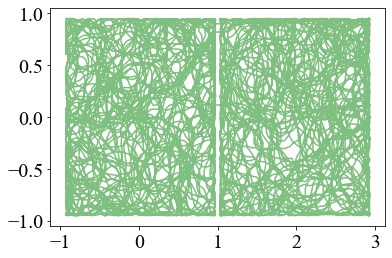

In [9]:
# plt.scatter(*x.T, alpha=0.5, color='green', s=1)
plt.plot(*x[:, :2].T, alpha=0.5, color='green')

In [10]:
u, r, phi, b = calc_u(x, change_int=len(x))

In [11]:
def restore(a_old, x_old, x_cur, B, u, T=100):
    Mu = get_Mu(u, 3)
    v = Mu.T @ (x_cur - x_old)
    b = v[2]
    r = np.linalg.norm(v[:2])
    phi = np.arctan2(v[1], v[0]) if r != 0 else 0
    Mu = Mu[:, :2]

    for _ in range(T):
        Wr = U @ np.diag(1j * B @ Mu @ [np.cos(phi), np.sin(phi)]) @ np.conj(U)
        Wb = U @ np.diag(1j * B @ u) @ np.conj(U)
        W = expm(Wr * r / T + Wb * b / T)
        a_old = W @ a_old
    
    return a_old

def sim_slope(x, r, phi, b, uncert=0, kappa=600, B_scale=10, B_rotz=8, mem=True):
    T = len(x)
    
    B = init_B(B_scale, rotz=B_rotz)

    a = np.zeros((T, 4), dtype='complex')
    a[0] = np.exp(2j * np.pi * np.array([0, 1/2, 1, 3/4]))

    I = np.identity(4)
    u0 = np.array([0, 0, 1])

    if uncert >= 1:
        u2 = np.squeeze(vonmisesfisher3d.x[vonmisesfisher3d.rvs(u0, kappa)])
    if uncert == 2:
        u1 = np.squeeze(vonmisesfisher3d.x[vonmisesfisher3d.rvs(u0, kappa)])
        
    restore_location_p1, restore_location_p2 = None, None
    prev_is_flat = True
    for t in range(1, T):
        if x[t, 0] > 1: # Slope
            B = init_B(B_scale * 1.2, rotz=B_rotz)
            u_ = u2 if uncert >= 1 else u0
            
            if prev_is_flat:
                prev_is_flat = False
                if mem:
                    restore_location_p1 = (a[t-1], x[t-1])
                    if restore_location_p2 is not None: # Restore phase
                        a[t] = restore(*restore_location_p2, x[t], B, u_)
                        continue
            
        else: # Flat
            B = init_B(B_scale, rotz=B_rotz)
            u_ = u1 if uncert == 2 else u0
            
            if not prev_is_flat:
                prev_is_flat = True
                if mem:
                    restore_location_p2 = (a[t-1], x[t-1])
                    if restore_location_p1 is not None: # Restore phase
                        a[t] = restore(*restore_location_p1, x[t], B, u_)
                        continue
            
        if (r[t-1] == 0) and (b[t-1] == 0):
            a[t] = a[t-1]
            continue

        Mu = get_Mu(u_)
        Wr = U @ np.diag(1j * B @ Mu @ [np.cos(phi[t-1]), np.sin(phi[t-1])]) @ np.conj(U)
        Wb = U @ np.diag(1j * B @ u_) @ np.conj(U)
    #     W = I + Wr * dr[t-1] + Wr @ Wr * dr[t-1]**2/2 + Wb * db + Wb @ Wb * db**2/2
        W = expm(Wr * r[t-1] + Wb * b[t-1])
        a[t] = W @ a[t-1]
    return activity(a)

In [12]:
a1 = sim_slope(x, r, phi, b, B_scale=10, mem=False) 
spikes1 = np.random.poisson(lam=1/(1 + np.exp(-(a1 - 0.6) * 30)), size=(len(a1), 4))
spikes1_ = spikes1.copy()
spikes1_[spikes1_ > 1] = 1

In [13]:
a2 = sim_slope(x, r, phi, b, B_scale=10, mem=True) 
spikes2 = np.random.poisson(lam=1/(1 + np.exp(-(a2 - 0.6) * 30)), size=(len(a2), 4))
spikes2_ = spikes2.copy()
spikes2_[spikes2_ > 1] = 1

In [14]:
a, spikes = (a1, a2), (spikes1_, spikes2_)

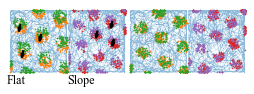

In [47]:
t1 = 0
t2 = t1 + i1_exit
t3 = t2 + i2_exit
t4 = t3 + i3_exit

n = 2

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1, n, sharex='all', sharey='all')

for i in range(n):
    idx = spikes[i][:, 0] >= 1

    ax[i].plot(*x[:, :2].T, linewidth=0.25, alpha=0.5, zorder=1) # Trajectory
    ax[i].plot(*x[t1:t2, :2][idx[t1:t2]].T, 'o', markersize=0.5, zorder=2)
    ax[i].plot(*x[t3:t4, :2][idx[t3:t4]].T, 'o', markersize=0.5, zorder=2)
    ax[i].plot(*x[t2:t3, :2][idx[t2:t3]].T, 'o', markersize=0.5, zorder=2)
    ax[i].plot(*x[t4:, :2][idx[t4:]].T, 'o', markersize=0.5, zorder=2) 
    ax[i].set_xlim([-1, 3])
    ax[i].set_axis_off()
    
ax[0].arrow(0.1, 0.2, -0.05, -0.2, length_includes_head=True, color='k', head_width=0.07, linewidth=2, zorder=3)
ax[0].arrow(-0.5, -0.3, -0.05, -0.2, length_includes_head=True, color='k', head_width=0.07, linewidth=2, zorder=3)
ax[0].arrow(-0.6, 0.5, -0.05, -0.2, length_includes_head=True, color='k', head_width=0.07, linewidth=2, zorder=3)
ax[0].arrow(2.0, 0.3, -0.05, -0.2, length_includes_head=True, color='k', head_width=0.07, linewidth=2, zorder=3)
ax[0].arrow(2.50, 0.6, -0.05, -0.2, length_includes_head=True, color='k', head_width=0.07, linewidth=2, zorder=3)
ax[0].arrow(2.55, 0.05, -0.05, -0.2, length_includes_head=True, color='k', head_width=0.07, linewidth=2, zorder=3)
fig.text(0, -0.1, 'Flat')
fig.text(0.25, -0.1, 'Slope')
fig.set_size_inches(85*MM, 25*MM)
fig.tight_layout(pad=0.1)
fig.savefig('figures/phase_shift_exp.pdf', transparent=True, dpi=300, pad_inches=0, bbox_inches='tight')

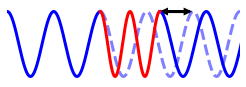

In [2]:
x_cos1 = np.linspace(0, 10.56, num=800)
y_cos1 = np.cos(np.pi * x_cos1)
x_cos2 = np.linspace(4, 6.56, num=200)
y_cos2 = np.cos(25/16 * np.pi * (x_cos2 - 4))
x_cos3 = np.linspace(6.56, 10.56, num=200)
y_cos3 = np.cos(np.pi * (x_cos3 - 6.56))

fig, ax = plt.subplots(1, figsize=(8, 2))
ax.plot(x_cos1[x_cos1 < 4], y_cos1[x_cos1 < 4], color='b', linewidth=3)
ax.plot(x_cos1[x_cos1 >= 4], y_cos1[x_cos1 >= 4], color='b', alpha=0.5, linestyle='--', linewidth=3)
ax.plot(x_cos3, y_cos3, color='b', linewidth=3)
ax.plot(x_cos2, y_cos2, color='r', linewidth=3)

ax.arrow(6.7, 1, 1.1, 0, length_includes_head=True, color='k', head_width=0.1, linewidth=3)
ax.arrow(7.8, 1, -1.1, 0, length_includes_head=True, color='k', head_width=0.1, linewidth=3)
ax.set_xlim([0, 10])
ax.set_axis_off()
fig.tight_layout(pad=0.5)
fig.set_size_inches(85*MM, 30*MM)
fig.savefig('figures/phase_shift_concept.pdf', transparent=True, dpi=300, pad_inches=0)